# Starting Kit - FAIR UNIVERSE: HIGGSML UNCERTAINTY CHALLENGE

For Overview and Decriptions of the competition, please visit the competition page

## Setup
`COLAB` determines whether this notebook is running on Google Colab.

In [1]:
COLAB = 'google.colab' in str(get_ipython())

In [2]:
if COLAB:
    %pip install HiggsML
    ! git clone https://github.com/blackSwanCS/Collaboration_A 
    %cd Collaboration_A


In [3]:
TEST_SETTINGS = {
"systematics": {  # Systematics to use
    "tes": True, # tau energy scale
    "jes": False, # jet energy scale
    "soft_met": False, # soft term in MET
    "w_scale": False, # W boson scale factor
    "bkg_scale": False, # Background scale factor
    },
"num_pseudo_experiments" : 2 , # Number of pseudo-experiments to run per set
"num_of_sets" : 5, # Number of sets of pseudo-experiments to run
} 

USE_RANDOM_MUS = True

## Existing Submissions
By this point you should have a clone of the repo which contains `HiggsML_Dummy_Submission.zip` which you can submit to the Competition

For more sample submissions please check `/HEP-Challenge/example_submissions/`

### Imports

In [4]:
from sys import path
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from itertools import product
from numpy.random import RandomState
import warnings
import os
import sys
warnings.filterwarnings("ignore")

### Directories

In [5]:

root_dir = os.getcwd()
print("Root directory is", root_dir)

input_dir = os.path.join(root_dir, "sample_data")
output_dir = os.path.join(root_dir, "sample_result_submission")
submission_dir = os.path.join(root_dir, "sample_code_submission")
score_dir = os.path.join(root_dir, "scoring_program")
    
test_settings = TEST_SETTINGS.copy()

if USE_RANDOM_MUS:
    test_settings[ "ground_truth_mus"] = (np.random.uniform(0.1, 3, test_settings["num_of_sets"])).tolist()
    
    random_settings_file = os.path.join(output_dir, "random_mu.json")
    with open(random_settings_file, "w") as f:
        json.dump(test_settings, f)
else:
    test_settings_file = os.path.join(input_dir, "test", "settings", "data.json")
    with open(test_settings_file) as f:
        test_settings = json.load(f)


Root directory is /home/chakkappai/Work/ST4_CS/Collaboration_A



### Add directories to path

In [6]:
path.append(submission_dir)
path.append(score_dir)

***
# Internal imports
***

In [7]:
import HiggsML.visualization as visualization
from HiggsML.systematics import systematics

***
# Import Submission Model
***
We import a class named `Model` from the submission file (`model.py`). This `Model` class has the following methods:
- `init`: receives train set and systematics class as input
- `fit`: can be used for training
- `predict`: receives one test set and outputs a dictionary with the following keys
    - `mu_hat` : predicted mu $\hat{\mu}$
    - `delta_mu_hat`: $\Delta{\hat{\mu}}$ bound for $\mu$
    - `p16`: 16th percentile
    - `p84`: 84th percentile

In this example code, the `Model` class implements an XGBoost model which is trained to predict both the TES and the class label. You can find the code in `HEP-Challenge/sample_code_submission/model.py`. You can modify it the way you want, keeping the required class structure and functions there. More instructions are given inside the `model.py` file. If running in Collab, click the folder icon in the left sidebar to open the file browser.

### ⚠️ Note:
In real setting i.e. the challenge itself, the submitted model is initialized once with train set and systematics class and the `predict` is called multiple times, each time with a different test sets. 

In [8]:
from model import Model

***
## Data
***

### ⚠️ Note:
The data used here is a small sample data is for demonstration only to get a view of what the data looks like. 

`USE_PUBLIC_DATASET` determines whether to use a public dataset provided for the participants or use a small sample datafor quick execution of this notebook

In [9]:
USE_PUBLIC_DATASET = True

`USE_PUBLIC_DATASET` determines whether to use a public dataset provided for the participants or use a small subset of the data for quick execution of this notebook

In [10]:
if USE_PUBLIC_DATASET:
    from HiggsML.datasets import Neurips2024_public_dataset as public_dataset
    data = public_dataset()
else:
    data = Data(input_dir)

The function loads the downloaded data in the public_data folder or downloads the data from codabench using `wget` in the absence of the downloaded data, 

In [11]:
# load train set
data.load_train_set()

[*] Loading Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569193 entries, 0 to 569192
Columns: 28 entries, PRI_lep_pt to DER_lep_eta_centrality
dtypes: float32(23), float64(5)
memory usage: 71.7 MB
None
[*] Train data loaded successfully


In [12]:
# load test sets
data.load_test_set()

[*] Loading Test data
[*] Test data loaded successfully


***
# Visualize
***
- Visualize Train set

In [13]:
train_visualize = visualization.Dataset_visualise(
    data_set=data.get_train_set(),
    columns=[
        "PRI_jet_leading_pt",
        "PRI_met",
        "PRI_lep_phi",
        "PRI_had_eta",
    ],
    name="Train Set",
)

In [14]:
# Show data summary
train_visualize.examine_dataset()

[*] --- Dataset name : Train Set
[*] --- Number of events : 569193
[*] --- Number of features : 28
   diboson   2147802.8624231685
   htautau   14139.779628584938
   ttbar   617397.1365783795
   wjets   2707034.6265619155
   ztautau   6172741.347195537
[*] --- Number of signal events : 495453
[*] --- Number of background events : 73740
[*] --- Examples of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_n_jets,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
0,27.165001,-0.297,2.544,47.249001,-0.648,-0.861,47.249001,-0.648,-0.861,-7.000000,...,10.386000,-7.000,-7.0,-7.000,2.899,10.386000,121.663002,0.575,-1.401,-7.000
1,38.069000,-0.128,-2.209,27.018999,-0.562,1.068,75.685997,1.410,1.256,27.572001,...,94.983002,0.548,-0.0,2.760,3.037,24.910999,195.365005,1.409,-1.288,0.000
2,29.386000,-1.051,1.522,35.452999,0.837,-0.687,35.452999,0.837,-0.687,-7.000000,...,39.750999,-7.000,-7.0,-7.000,2.906,39.750999,100.292000,0.829,1.153,-7.000
3,23.280001,0.381,3.018,36.963001,-0.266,2.123,202.218994,-1.029,-0.695,36.963001,...,217.839996,3.152,-0.0,-2.185,1.104,21.841999,299.424988,0.630,1.273,0.989
4,53.756001,-0.990,1.208,53.890999,-1.334,-2.377,53.890999,-1.334,-2.377,36.070999,...,25.167999,0.724,-0.0,0.814,2.720,77.138000,197.608994,0.998,-1.245,0.998


[*] --- Description of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_n_jets,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
count,569193.000000,569193.000000,569193.000000,569193.000000,569193.000000,569193.000000,569193.000000,569193.00000,569193.000000,569193.000000,...,569193.000000,569193.000000,569193.000000,569193.000000,569193.000000,569193.000000,569193.000000,569193.000000,569193.000000,569193.000000
mean,41.387417,0.001487,-0.002448,51.890438,0.001784,0.002107,78.490112,0.00030,0.000207,36.630913,...,66.892799,-0.725855,10.855216,-2.122440,2.538017,51.574989,241.471054,0.945472,0.422400,-1.858387
std,25.014723,1.163863,1.813969,28.331236,1.196417,1.813287,59.904461,1.55565,1.813391,41.240211,...,70.637108,4.312909,30.949367,4.104174,0.706812,56.374832,160.145798,0.694715,1.124003,3.411420
min,20.000000,-2.500000,-3.142000,22.861000,-2.686000,-3.142000,22.944000,-4.92400,-3.142000,-7.000000,...,0.041000,-7.000000,-7.000000,-14.626000,0.518000,0.041000,66.679001,0.034000,-1.414000,-7.000000
25%,26.266001,-0.879000,-1.573000,34.567001,-0.914000,-1.567000,43.333000,-1.11500,-1.573000,-7.000000,...,18.920000,-7.000000,-7.000000,-7.000000,2.089000,15.472000,135.414993,0.532000,-0.884000,-7.000000
50%,34.266998,0.002000,-0.006000,45.452999,0.003000,0.008000,58.619999,0.00200,0.001000,33.881001,...,41.824001,0.952000,0.000000,-1.178000,2.758000,32.457001,188.164993,0.769000,1.054000,0.006000
75%,47.145000,0.883000,1.570000,59.737999,0.919000,1.570000,90.540001,1.11600,1.570000,55.120998,...,90.328003,2.380000,15.319000,0.624000,3.070000,70.170998,297.140015,1.128000,1.369000,0.565000
max,1026.430054,2.500000,3.142000,778.645996,2.680000,3.142000,1166.640015,4.92400,3.142000,696.237000,...,1167.008057,7.845000,817.351000,14.638000,5.829000,1797.446045,2939.478027,23.846001,1.414000,1.000000


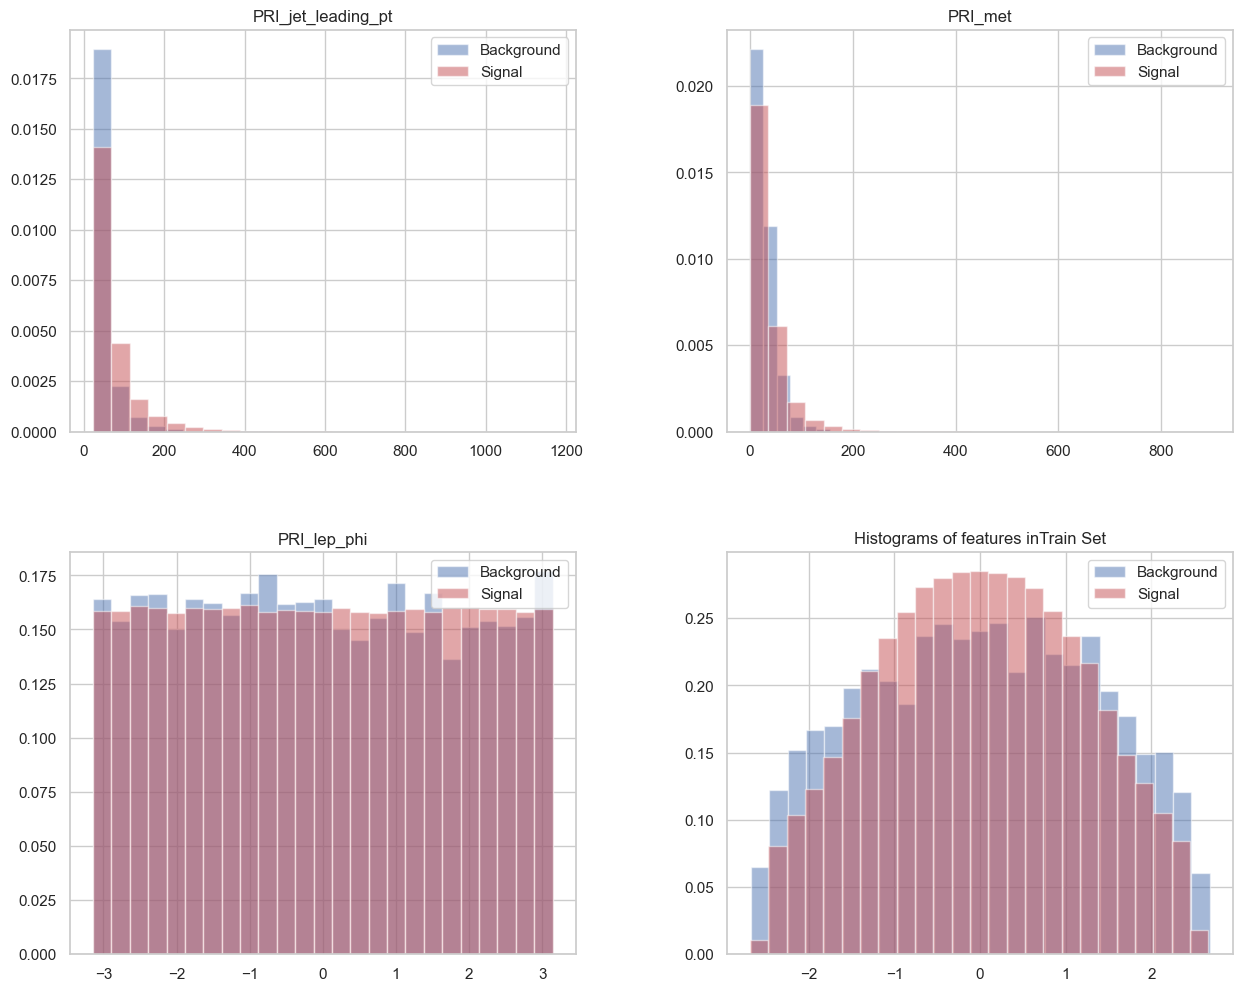

In [15]:
# Show data summary
train_visualize.histogram_dataset()

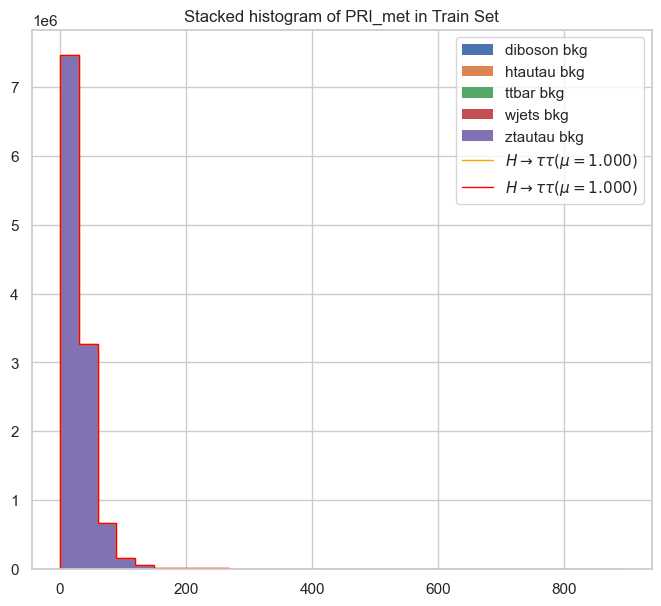

In [16]:
train_visualize.stacked_histogram("PRI_met")

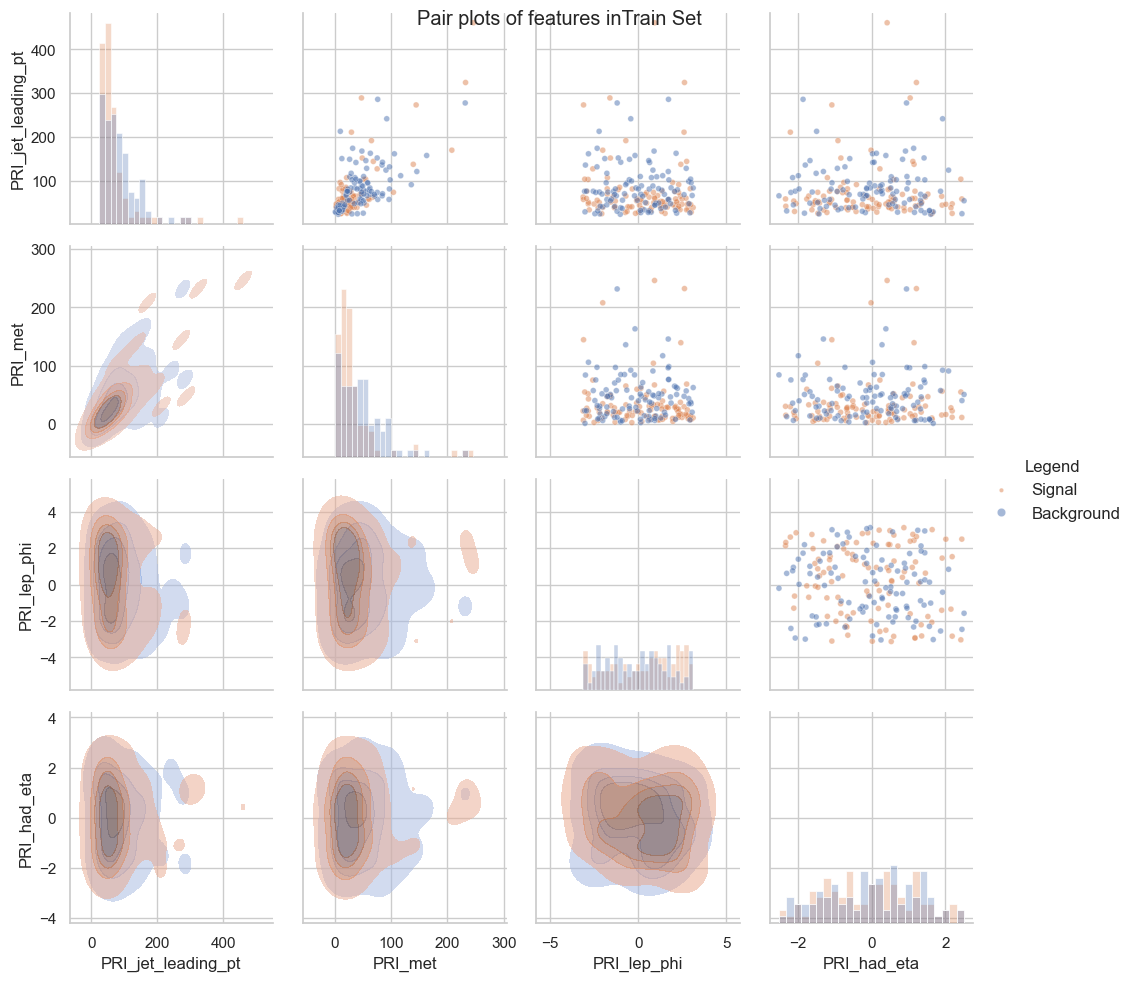

In [17]:
# Show data summary
train_visualize.pair_plots(sample_size=100)

In [18]:
syst_train_data = data.get_syst_train_set()

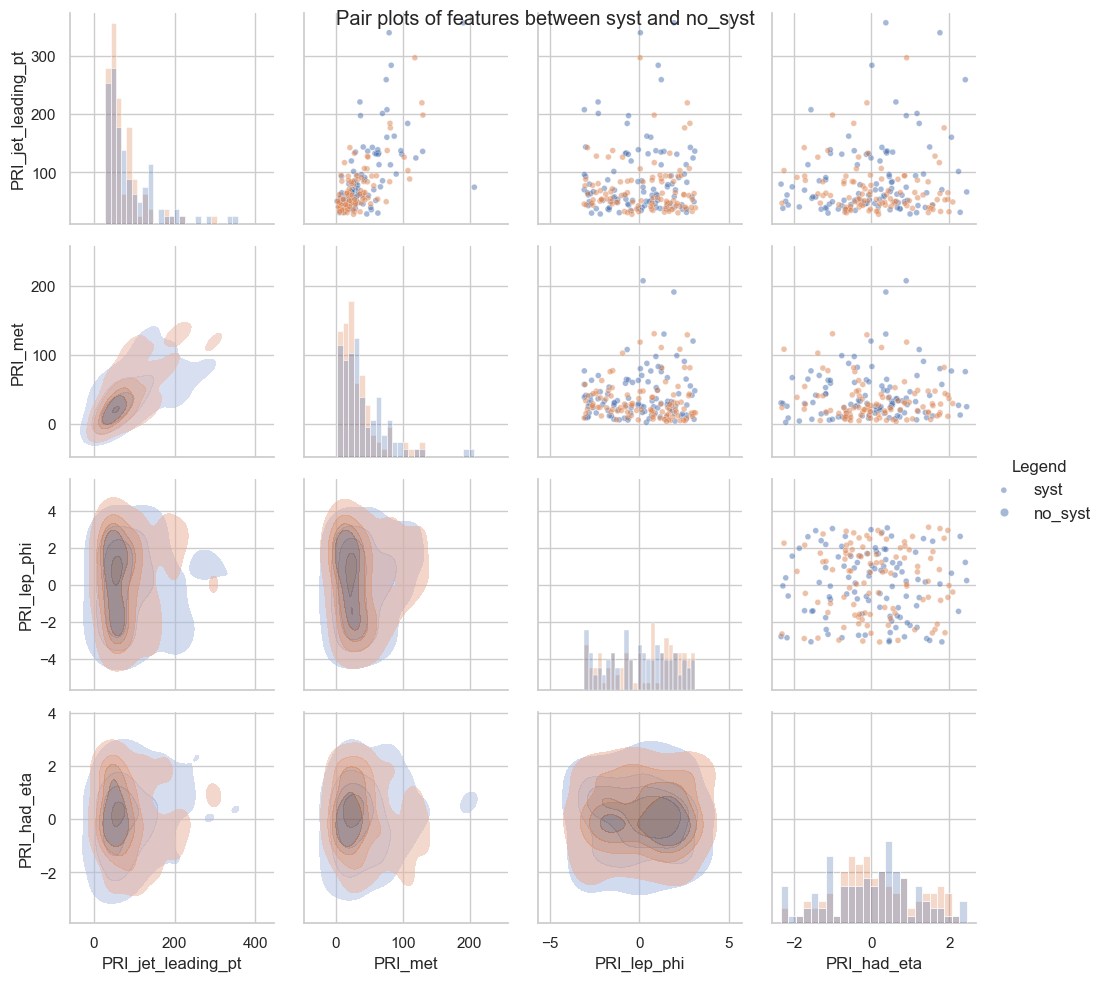

In [19]:
# Pair plots of train set with systematics
train_visualize.pair_plots_syst(syst_train_data["data"], sample_size=100)

In [20]:
bootstraped_data = data.generate_psuedo_exp_data()

In [21]:
# Show data summary
train_visualize.examine_dataset()

[*] --- Dataset name : Train Set
[*] --- Number of events : 569193
[*] --- Number of features : 28
   diboson   2147802.8624231685
   htautau   14139.779628584938
   ttbar   617397.1365783795
   wjets   2707034.6265619155
   ztautau   6172741.347195537
[*] --- Number of signal events : 495453
[*] --- Number of background events : 73740
[*] --- Examples of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_n_jets,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
0,27.165001,-0.297,2.544,47.249001,-0.648,-0.861,47.249001,-0.648,-0.861,-7.000000,...,10.386000,-7.000,-7.0,-7.000,2.899,10.386000,121.663002,0.575,-1.401,-7.000
1,38.069000,-0.128,-2.209,27.018999,-0.562,1.068,75.685997,1.410,1.256,27.572001,...,94.983002,0.548,-0.0,2.760,3.037,24.910999,195.365005,1.409,-1.288,0.000
2,29.386000,-1.051,1.522,35.452999,0.837,-0.687,35.452999,0.837,-0.687,-7.000000,...,39.750999,-7.000,-7.0,-7.000,2.906,39.750999,100.292000,0.829,1.153,-7.000
3,23.280001,0.381,3.018,36.963001,-0.266,2.123,202.218994,-1.029,-0.695,36.963001,...,217.839996,3.152,-0.0,-2.185,1.104,21.841999,299.424988,0.630,1.273,0.989
4,53.756001,-0.990,1.208,53.890999,-1.334,-2.377,53.890999,-1.334,-2.377,36.070999,...,25.167999,0.724,-0.0,0.814,2.720,77.138000,197.608994,0.998,-1.245,0.998


[*] --- Description of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_n_jets,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
count,569193.000000,569193.000000,569193.000000,569193.000000,569193.000000,569193.000000,569193.000000,569193.00000,569193.000000,569193.000000,...,569193.000000,569193.000000,569193.000000,569193.000000,569193.000000,569193.000000,569193.000000,569193.000000,569193.000000,569193.000000
mean,41.387417,0.001487,-0.002448,51.890438,0.001784,0.002107,78.490112,0.00030,0.000207,36.630913,...,66.892799,-0.725855,10.855216,-2.122440,2.538017,51.574989,241.471054,0.945472,0.422400,-1.858387
std,25.014723,1.163863,1.813969,28.331236,1.196417,1.813287,59.904461,1.55565,1.813391,41.240211,...,70.637108,4.312909,30.949367,4.104174,0.706812,56.374832,160.145798,0.694715,1.124003,3.411420
min,20.000000,-2.500000,-3.142000,22.861000,-2.686000,-3.142000,22.944000,-4.92400,-3.142000,-7.000000,...,0.041000,-7.000000,-7.000000,-14.626000,0.518000,0.041000,66.679001,0.034000,-1.414000,-7.000000
25%,26.266001,-0.879000,-1.573000,34.567001,-0.914000,-1.567000,43.333000,-1.11500,-1.573000,-7.000000,...,18.920000,-7.000000,-7.000000,-7.000000,2.089000,15.472000,135.414993,0.532000,-0.884000,-7.000000
50%,34.266998,0.002000,-0.006000,45.452999,0.003000,0.008000,58.619999,0.00200,0.001000,33.881001,...,41.824001,0.952000,0.000000,-1.178000,2.758000,32.457001,188.164993,0.769000,1.054000,0.006000
75%,47.145000,0.883000,1.570000,59.737999,0.919000,1.570000,90.540001,1.11600,1.570000,55.120998,...,90.328003,2.380000,15.319000,0.624000,3.070000,70.170998,297.140015,1.128000,1.369000,0.565000
max,1026.430054,2.500000,3.142000,778.645996,2.680000,3.142000,1166.640015,4.92400,3.142000,696.237000,...,1167.008057,7.845000,817.351000,14.638000,5.829000,1797.446045,2939.478027,23.846001,1.414000,1.000000


***
### Program
***


In [22]:

from HiggsML.ingestion import Ingestion

ingestion = Ingestion(data)


In [23]:

# initialize submission
ingestion.init_submission(Model)

[*] Initializing Submmited Model
[*] Loading Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569193 entries, 0 to 569192
Columns: 28 entries, PRI_lep_pt to DER_lep_eta_centrality
dtypes: float32(23), float64(5)
memory usage: 71.7 MB
None
[*] Train data loaded successfully
Full data:  (569193, 28)
Full Labels:  (569193,)
Full Weights:  (569193,)
sum_signal_weights:  14139.779628584938
sum_bkg_weights:  11644975.972759
 
 
Train Data:  (465879, 28)
Train Labels:  (465879,)
Train Weights:  (465879,)
sum_signal_weights:  14139.779628584934
sum_bkg_weights:  11644975.972759

Valid Data:  (113838, 28)
Valid Labels:  (113838,)
Valid Weights:  (113838,)
sum_signal_weights:  14139.779628584938
sum_bkg_weights:  11644975.972759001
 
 
Training Data:  (465879, 29)
Model is BDT


[*] Calling fit method of submitted model
Score plus syst:  (449400,)
Score minus syst:  (433367,)
train Results:  {'mu_hat': 0.6990472068398581, 'del_mu_stat': 0.00044238828587798637, 'del_mu_sys': 0.06990472068398582, 'del_mu_tot': 0.03495306024263668}
valid Results:  {'mu_hat': 0.7581152902995985, 'del_mu_stat': 0.00044238828587798637, 'del_mu_sys': 0.07581152902995986, 'del_mu_tot': 0.03790640988426604}


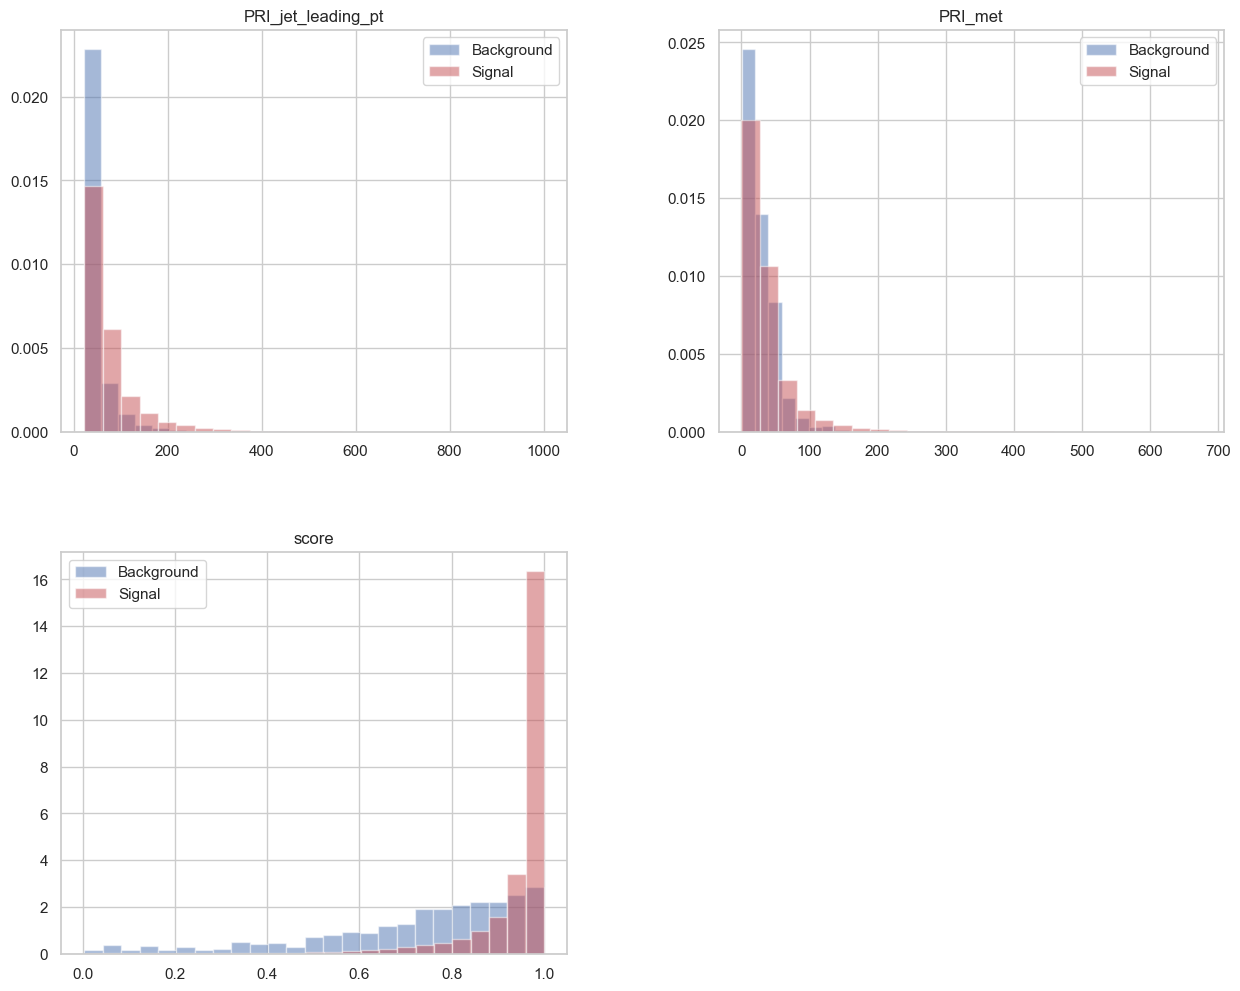

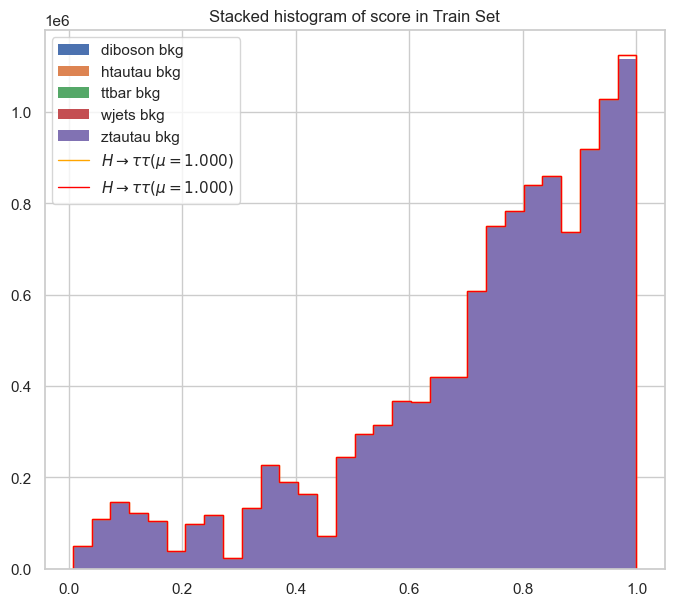

In [24]:

# fit submission
ingestion.fit_submission()

In [25]:

# load test set
data.load_test_set()

[*] Loading Test data
[*] Test data loaded successfully


In [26]:

# predict submission
ingestion.predict_submission(test_settings)

[*] Calling predict method of submitted model
Test Results:  {'mu_hat': 0.745193479011056, 'del_mu_stat': 0.00044238828587798637, 'del_mu_sys': 0.0745193479011056, 'del_mu_tot': 0.03726033051048224}
Test Results:  {'mu_hat': 0.7191274825478866, 'del_mu_stat': 0.00044238828587798637, 'del_mu_sys': 0.07191274825478866, 'del_mu_tot': 0.03595705448501063}
Test Results:  {'mu_hat': 0.6559121688264471, 'del_mu_stat': 0.00044238828587798637, 'del_mu_sys': 0.06559121688264472, 'del_mu_tot': 0.03279635436882283}
Test Results:  {'mu_hat': 0.778083092258622, 'del_mu_stat': 0.00044238828587798637, 'del_mu_sys': 0.07780830922586221, 'del_mu_tot': 0.03890478342049624}
Test Results:  {'mu_hat': 0.7599093401255719, 'del_mu_stat': 0.00044238828587798637, 'del_mu_sys': 0.07599093401255719, 'del_mu_tot': 0.037996110851955305}
Test Results:  {'mu_hat': 0.8490479716246854, 'del_mu_stat': 0.00044238828587798637, 'del_mu_sys': 0.08490479716246854, 'del_mu_tot': 0.042452974832735246}
Test Results:  {'mu_hat':

In [27]:
ingestion.compute_result()

[*] Saving ingestion result


In [28]:

# save result
ingestion.save_result(output_dir)

***
# Score
***
1. Compute Scores
2. Visualize Scores


In [29]:


def visualize_scatter(ingestion_result_dict, ground_truth_mus):
    plt.figure(figsize=(6, 4))
    for key in ingestion_result_dict.keys():
        ingestion_result = ingestion_result_dict[key]
        mu_hat = np.mean(ingestion_result["mu_hats"])
        mu = ground_truth_mus[key]
        plt.scatter(mu, mu_hat, c='b', marker='o')
    
    plt.xlabel('Ground Truth $\mu$')
    plt.ylabel('Predicted $\mu$ (averaged for 100 test sets)')
    plt.title('Ground Truth vs. Predicted $\mu$ Values')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()



In [30]:
from HiggsML.score import Scoring

In [31]:
# Initialize Score
score = Scoring()

In [32]:
print(output_dir)
score.load_ingestion_results(prediction_dir = output_dir)

/home/chakkappai/Work/ST4_CS/Collaboration_A/sample_result_submission
[*] Reading predictions
[✔]


[*] Computing scores
[*]  [{'mu_hats': [0.745193479011056, 2.1048949072562024], 'delta_mu_hats': [0.03726033051048224, 0.10524497780574432], 'p16': [0.7079331485005738, 1.9996499294504582], 'p84': [0.7824538095215383, 2.2101398850619467]}, {'mu_hats': [2.410265011094069, 0.6559121688264471], 'delta_mu_hats': [0.1205134535481811, 0.03279635436882283], 'p16': [2.289751557545888, 0.6231158144576243], 'p84': [2.53077846464225, 0.6887085231952699]}, {'mu_hats': [0.778083092258622, 0.8490479716246854], 'delta_mu_hats': [0.03890478342049624, 0.042452974832735246], 'p16': [0.7391783088381259, 0.8065949967919501], 'p84': [0.8169878756791182, 0.8915009464574206]}, {'mu_hats': [1.445553349860582, 1.0525877479643695], 'delta_mu_hats': [0.07227800595673448, 0.05262985222058512], 'p16': [1.3732753439038474, 0.9999578957437844], 'p84': [1.5178313558173164, 1.1052176001849545]}, {'mu_hats': [0.7191274825478866, 0.7599093401255719], 'delta_mu_hats': [0.03595705448501063, 0.037996110851955305], 'p16': [

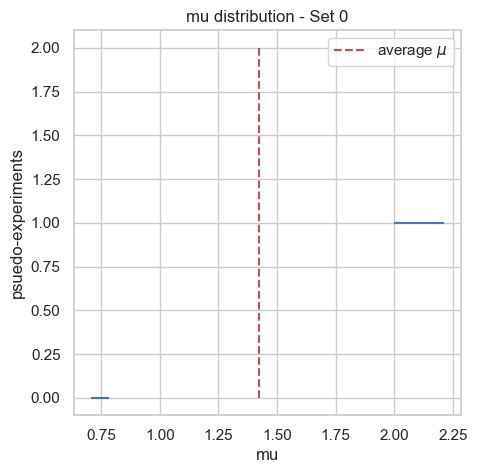

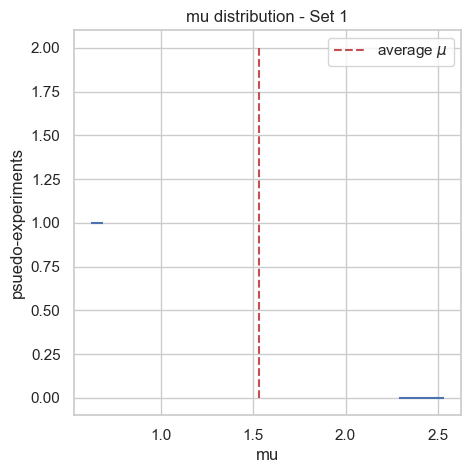

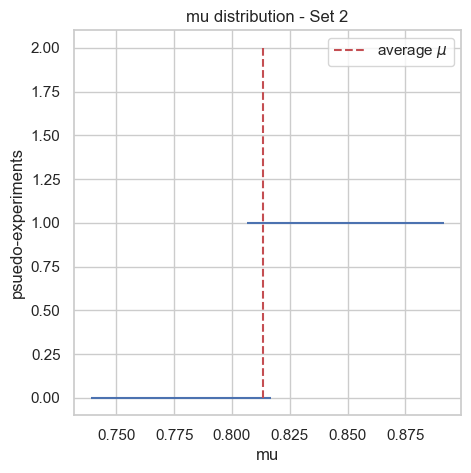

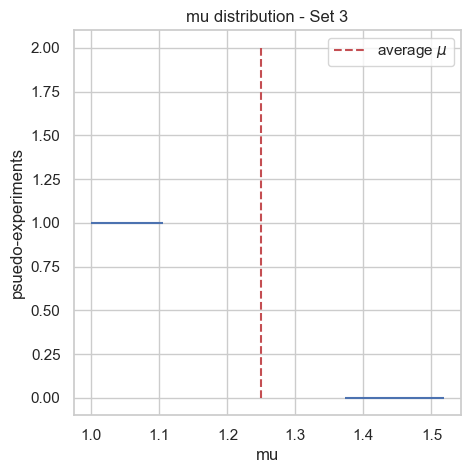

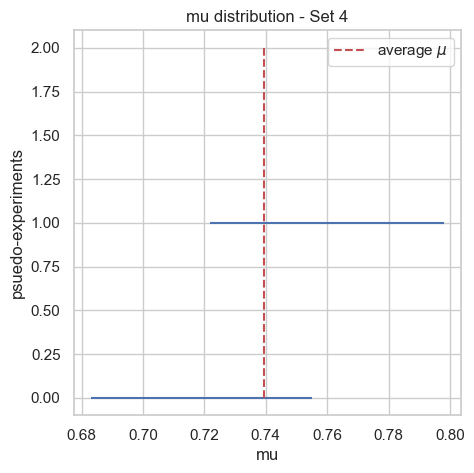

In [33]:
# Compute Score
score.compute_scores(test_settings)

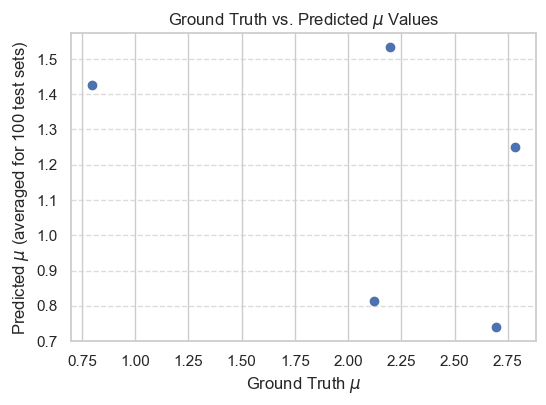

In [34]:
# Visualize scatter plot of ground truth mu and predicted mu
visualize_scatter(ingestion_result_dict=ingestion.results_dict, 
                  ground_truth_mus=test_settings["ground_truth_mus"])

***
# Submissions
***

### **Unit Testing**

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission.
<br>
Keep the sample code simple.<br>

<code>python3</code> is required for this step

### **Test Ingestion Program**
⚠️ Note: Ingestion program runs by default a small dataset. To run it on public data set `USE_PUBLIC_DATA = True`

In [35]:
!python3 run_ingestion.py

[*] Initializing Submmited Model
[*] Loading Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569193 entries, 0 to 569192
Columns: 28 entries, PRI_lep_pt to DER_lep_eta_centrality
dtypes: float32(23), float64(5)
memory usage: 71.7 MB
None
[*] Train data loaded successfully
Full data:  (569193, 28)
Full Labels:  (569193,)
Full Weights:  (569193,)
sum_signal_weights:  14139.779628584938
sum_bkg_weights:  11644975.972759
 
 
Train Data:  (465879, 28)
Train Labels:  (465879,)
Train Weights:  (465879,)
sum_signal_weights:  14139.779628584934
sum_bkg_weights:  11644975.972759

Valid Data:  (113838, 28)
Valid Labels:  (113838,)
Valid Weights:  (113838,)
sum_signal_weights:  14139.779628584938
sum_bkg_weights:  11644975.972759001
 
 
Training Data:  (465879, 29)
Model is BDT
[*] Calling fit method of submitted model
Score plus syst:  (449400,)
Score minus syst:  (433367,)
train Results:  {'mu_hat': 0.6990472068398581, 'del_mu_stat': 0.00044238828587798637, 'del_mu_sys': 0.069904720

### **Test Scoring Program**

In [36]:
!python3 run_scoring.py

Settings file not found. Please provide the settings file.


In [37]:
from zipfile import ZipFile, ZIP_DEFLATED
from contextlib import closing
# -------------------------------------
# Zip files
# -------------------------------------
def zipdir(archivename, basedir):
    '''Zip directory, from J.F. Sebastian http://stackoverflow.com/'''
    assert os.path.isdir(basedir)
    with closing(ZipFile(archivename, "w", ZIP_DEFLATED)) as z:
        for root, dirs, files in os.walk(basedir):
            # NOTE: ignore empty directories
            for fn in files:
                if fn[-4:] != '.zip' and fn != '.DS_Store':
                    absfn = os.path.join(root, fn)
                    zfn = absfn[len(basedir):]  # XXX: relative path
                    z.write(absfn, zfn)

### **Prepare the submission**

In [38]:
import datetime
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
code_submission = 'BlackSwan-code_submission_' + the_date + '.zip'
zipdir(code_submission, submission_dir)
print("Submit : " + code_submission + " to the competition")


Submit : BlackSwan-code_submission_24-05-22-14-06.zip to the competition
